### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

## 0. Libraries installation

In [2]:
!pip install numpy pandas matplotlib scikit-learn tensorflow 


ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [3]:
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 167.4 MB/s eta 0:00:0000:01


## 1. Load the images and extract the features

In [21]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2
import shutil
import joblib
import IPython.display as ipd

In [32]:
# Load the pre-trained model (VGG16)
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

# Directory containing your images
image_dir = 'images_for_clustering/frechen'

# Directory to save the preprocessed images
preprocessed_dir = 'preprocessed_img/'
os.makedirs(preprocessed_dir, exist_ok=True)

# Function to load an image, crop to the stamp, preprocess it, and save the preprocessed version
def load_preprocess_and_save_image(img_path, preprocessed_dir, img_name):
    # Load the original image
    original_img = cv2.imread(img_path)
    
    if original_img is None:
        print(f"Error loading image: {img_path}")
        return None

    # Convert the image to grayscale
    gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

    # Use HoughCircles to detect circles (stamps) in the image
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=10, maxRadius=100)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        # Assuming the first detected circle is the stamp
        x, y, r = circles[0]
        
        # Crop the image to the bounding box around the detected circle (stamp)
        x_start = max(x - r, 0)
        y_start = max(y - r, 0)
        x_end = min(x + r, original_img.shape[1])
        y_end = min(y + r, original_img.shape[0])
        
        cropped_img = original_img[y_start:y_end, x_start:x_end]
    else:
        # If no circle is detected, use the entire image
        cropped_img = original_img

    # Convert the cropped region to a format suitable for VGG16
    cropped_img_resized = cv2.resize(cropped_img, (224, 224))

    # Save the cropped and resized image to the preprocessed directory
    save_path = os.path.join(preprocessed_dir, img_name)
    cv2.imwrite(save_path, cropped_img_resized)

    # Preprocess the image for VGG16
    cropped_img_resized = image.img_to_array(cropped_img_resized)
    cropped_img_resized = np.expand_dims(cropped_img_resized, axis=0)
    cropped_img_resized = preprocess_input(cropped_img_resized)
    
    return cropped_img_resized

# Extract features from all images and save preprocessed images
def extract_and_save_features(image_dir, preprocessed_dir):
    features = []
    image_paths = []
    preprocessed_images = {}
    
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        
        # Skip directories and hidden files
        if os.path.isdir(img_path) or img_name.startswith('.'):
            continue
        
        # Load, crop, preprocess, and save the preprocessed image
        processed_img_array = load_preprocess_and_save_image(img_path, preprocessed_dir, img_name)
        
        if processed_img_array is None:
            continue
        
        # Predict features using the VGG16 model
        feature = model.predict(processed_img_array)
        
        features.append(feature.flatten())
        image_paths.append(img_path)
        
        # Save the preprocessed image in the dictionary for later use
        preprocessed_images[img_path] = processed_img_array[0]  # Store the preprocessed image without batch dimension
    
    return np.array(features), image_paths, preprocessed_images

# Run the feature extraction and saving process
features, image_paths, preprocessed_images = extract_and_save_features(image_dir, preprocessed_dir)



1/1 [==============================] - 0s 70ms/step


## 2. Apply clustering

In [33]:
# Apply K-Means clustering
num_clusters = 5  # You can change this based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(features)

# Get cluster labels
labels = kmeans.labels_

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## 3. Visualize the clusters

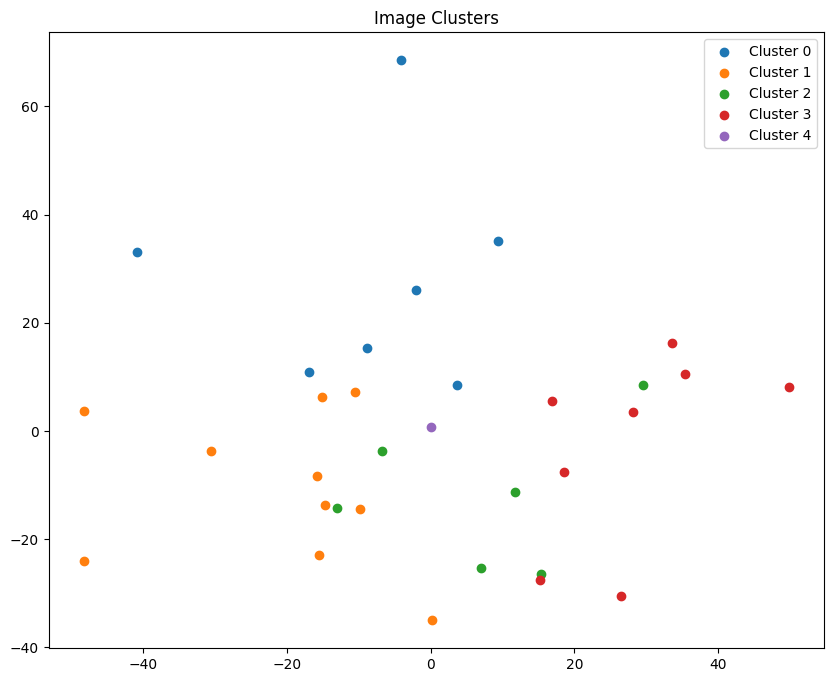

In [34]:
# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    cluster_points = reduced_features[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Image Clusters')
plt.show()


## 4: Review the Clustered Images

In [35]:
# Print image paths for each cluster
for i in range(num_clusters):
    print(f'Cluster {i}:')
    for img_path in np.array(image_paths)[labels == i]:
        print(img_path)
    print('\n')

Cluster 0:
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144437.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144511.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 142040.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144334.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 142201.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144343.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144402.png


Cluster 1:
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144326.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 141940.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 142154.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 142018.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 141953.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144419.png
images_for_clustering/frechen/Captura de

In [36]:
import shutil

# Create the base directory for clustered images
cluster_base_dir = 'clustered_images_focus/frenchen/'
os.makedirs(cluster_base_dir, exist_ok=True)

# Function to create directories for clusters and save original and preprocessed images
def save_clustered_images(image_paths, labels, cluster_base_dir, preprocessed_images):
    for cluster_num in np.unique(labels):
        cluster_dir = os.path.join(cluster_base_dir, f'cluster{cluster_num + 1}')
        os.makedirs(cluster_dir, exist_ok=True)
        
        cluster_images = np.array(image_paths)[labels == cluster_num]
        for img_path in cluster_images:
            # Copy the original image to the cluster directory
            shutil.copy(img_path, cluster_dir)
            
            # Save the preprocessed image to the cluster directory
            preprocessed_img = preprocessed_images[img_path]
            preprocessed_img_name = os.path.basename(img_path)
            preprocessed_save_path = os.path.join(cluster_dir, f'preprocessed_{preprocessed_img_name}')
            preprocessed_img = image.array_to_img(preprocessed_img)  # Convert back to PIL image
            preprocessed_img.save(preprocessed_save_path)

# Save the images (both original and preprocessed) in their respective cluster directories
save_clustered_images(image_paths, labels, cluster_base_dir, preprocessed_images)

print(f'Images have been saved in {cluster_base_dir} organized by clusters.')

Images have been saved in clustered_images_focus/frenchen/ organized by clusters.


In [37]:
import shutil

# Path to the directory you want to zip
folder_to_zip = '/home/datascience/clustered_images_focus/frenchen/'
zip_file_name = '/home/datascience/frenchen_clustered_images_focus.zip'

# Create a zip file
shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', folder_to_zip)

print(f'Folder {folder_to_zip} has been zipped as {zip_file_name}.')

Folder /home/datascience/clustered_images_focus/frenchen/ has been zipped as /home/datascience/frenchen_clustered_images_focus.zip.


In [28]:
import IPython.display as ipd

# Provide a download link
ipd.FileLink('/home/datascience/frenchen_clustered_images_focus.zip')

/home/datascience/frenchen_clustered_images_focus.zip

## 5. Saving and reusing the clustering model

In [29]:
import joblib

# Save the K-Means model
joblib.dump(kmeans, 'kmeans_model.pkl')

# To load the model later
# kmeans = joblib.load('kmeans_model.pkl')

['kmeans_model.pkl']